In [1]:
import os
import sys

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt
from scipy.spatial import distance
import gudhi, gudhi.hera, gudhi.wasserstein, persim
import json

In [3]:
import plotly
from plotly.graph_objs import graph_objs as go
import ipywidgets as widgets
plotly.offline.init_notebook_mode(connected=True)
from plotly.offline import iplot

In [4]:
import mdtraj
from mdtraj import load

In [5]:
#os.chdir(r"C:\code\data\Micelles_identification")
#os.chdir("/mnt/c/code/data/Micelles_identification")
os.chdir(r"Z:\data\micelles\Micelles_identification")

In [6]:
polyComp=os.listdir()
polyComp=[i for i in polyComp if i.find(".")==-1 and i!="High_conc"] #get rid of actionList if present -> do High_conc separately
polyComp

['L64', 'P104', 'P123', 'P65', 'P84', 'P85']

In [7]:
temps=[int(i)*10 for i in range(1,6)]
temps

[10, 20, 30, 40, 50]

# animSliderCode

In [12]:
def genAlphaSlider(dat,initial=.05,step=.25,maximum=20): #assume 3D for now
    ac = gudhi.AlphaComplex(dat)
    st = ac.create_simplex_tree()
    skel=list(st.get_skeleton(2))
    skel.sort(key=lambda s: s[1])
    points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
    lims=[[np.floor(np.min(dat[:,i])),np.ceil(np.max(dat[:,i]))] for i in range(3)]
    alpha = widgets.FloatSlider(
        value = initial,
        min = 0.0,
        max = maximum,
        step = step,
        description = 'Alpha:',
        readout_format = '.4f'
    )



    b1s=np.array([s[0] for s in skel if len(s[0]) == 2 and s[1] <= alpha.value])
    triangles = np.array([s[0] for s in skel if len(s[0]) == 3 and s[1] <= alpha.value])


    pts=go.Scatter3d(
        x = points[:, 0],
        y = points[:, 1],
        z = points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color="cornflowerblue",                # set color to an array/list of desired values
            #colorscale='Viridis',   # choose a colorscale
            opacity=.9
        ),
        name='H0'

    )

    sfig=[pts]

    linepts={0:[],1:[],2:[]}
    for i in b1s:
        linepts[0].append(points[i[0],0])
        linepts[1].append(points[i[0],1])
        linepts[2].append(points[i[0],2])
        linepts[0].append(points[i[1],0])
        linepts[1].append(points[i[1],1])
        linepts[2].append(points[i[1],2])

        linepts[0].append(None)
        linepts[1].append(None)
        linepts[2].append(None)

    if len(linepts[0])>0:
        lins=go.Scatter3d(
            x=linepts[0],
            y=linepts[1],
            z=linepts[2],
            mode='lines',
            name='H1',
            marker=dict(
                size=3,
                color="#d55e00",                # set color to an array/list of desired values
                #colorscale='Viridis',   # choose a colorscale
                opacity=.9
            )
        )
        sfig.append(lins)
        if len(triangles)>0:
            mesh = go.Mesh3d(
                x = points[:, 0],
                y = points[:, 1],
                z = points[:, 2],
                i = triangles[:, 0],
                j = triangles[:, 1],
                k = triangles[:, 2],
                color="#009e73",
                opacity=.75,
                name='H2'
            )


            sfig.append(mesh)
    fig=go.Figure(sfig)
    fig.update_layout(width=800,height=800)
    #fig.show()




    def view_SC(alpha):
        if alpha==0:
            fig=go.Figure(sfig[0])
            fig.show()
        else:
            b1s=np.array([s[0] for s in skel if len(s[0]) == 2 and s[1] <= alpha])

            linepts={0:[],1:[],2:[]}
            for i in b1s:
                linepts[0].append(points[i[0],0])
                linepts[1].append(points[i[0],1])
                linepts[2].append(points[i[0],2])
                linepts[0].append(points[i[1],0])
                linepts[1].append(points[i[1],1])
                linepts[2].append(points[i[1],2])

                linepts[0].append(None)
                linepts[1].append(None)
                linepts[2].append(None)

            if len(linepts[0])>0:
                lins=go.Scatter3d(
                    x=linepts[0],
                    y=linepts[1],
                    z=linepts[2],
                    mode='lines',
                    name='H1',
                    marker=dict(
                        size=3,
                        color="#d55e00",                # set color to an array/list of desired values
                        #colorscale='Viridis',   # choose a colorscale
                        opacity=.85
                    )
                )
                if len(sfig)>1:
                    sfig[1]=lins
                else:
                    sfig.append(lins)
                triangles = np.array([s[0] for s in skel if len(s[0]) == 3 and s[1] <= alpha])
                if len(triangles)>0:
                    mesh = go.Mesh3d(
                        x = points[:, 0],
                        y = points[:, 1],
                        z = points[:, 2],
                        i = triangles[:, 0],
                        j = triangles[:, 1],
                        k = triangles[:, 2],
                        color="#009e73",
                        opacity=.5,
                        name='H2'
                    )

                    if len(sfig)>1:
                        sfig[2]=mesh
                    else:
                        sfig.append(mesh)


            fig=go.Figure(data=sfig,layout=go.Layout(width=800,height=800,
                                                     title=f"Simplicial complex with radius <= {round(float(alpha),5)}",
                                                    ))

            #fig.show()
            iplot(fig)


    widgets.interact(view_SC, alpha = alpha);
    return st

In [9]:
polyComp

['L64', 'P104', 'P123', 'P65', 'P84', 'P85']

In [10]:
#Load a testdat

#comp=polyComp[0]
comp="P85"
temp=temps[0]
temp=30

groFile=mdtraj.load(f"{comp}/{comp}_{temp}.gro")

In [10]:
groFile=mdtraj.load(f"High_conc/P103/P103_35.gro")

In [15]:
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)

In [16]:
dat=p0Gro.xyz[0,:] #time 0

In [19]:
dat=p0Gro.xyz[22,:]

In [20]:
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

interactive(children=(FloatSlider(value=0.05, description='Alpha:', max=30.0, readout_format='.4f', step=0.5),…

In [23]:
st=genAlphaSlider(dat,initial=33,step=.5,maximum=40)

interactive(children=(FloatSlider(value=33.0, description='Alpha:', max=40.0, readout_format='.4f', step=0.5),…

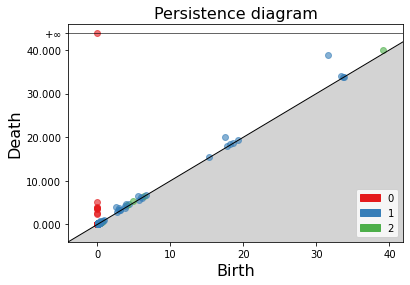

In [21]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [8]:
dat=p0Gro.xyz[0,:] #time 1
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

NameError: name 'p0Gro' is not defined

In [ ]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [11]:
dat=p0Gro.xyz[1,:] #time 1
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

interactive(children=(FloatSlider(value=0.05, description='Alpha:', max=30.0, readout_format='.4f', step=0.5),…

usetex mode requires TeX.


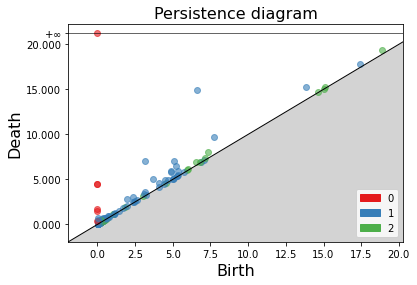

In [12]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [13]:
dat=p0Gro.xyz[2,:] #time 2
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

interactive(children=(FloatSlider(value=0.05, description='Alpha:', max=30.0, readout_format='.4f', step=0.5),…

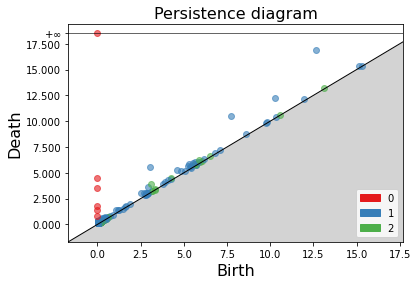

In [14]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [15]:
dat=p0Gro.xyz[3,:] #time 3
st=genAlphaSlider(dat,initial=.05,step=.5,maximum=30)

interactive(children=(FloatSlider(value=0.05, description='Alpha:', max=30.0, readout_format='.4f', step=0.5),…

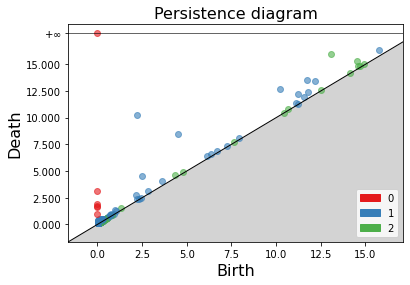

In [16]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [8]:
groFile=mdtraj.load(f"High_conc/P103/P103_25.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)
st=genAlphaSlider(dat=p0Gro.xyz[0,:],initial=.05,step=.5,maximum=30)

NameError: name 'genAlphaSlider' is not defined

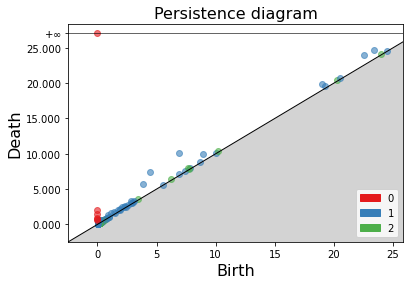

In [20]:
dgm=st.persistence()
gudhi.plot_persistence_diagram(dgm, legend = True)
plt.show()

In [25]:
minim=.05
sum([1 for i in dgm if i[0]==0])-sum([1 for i in dgm if i[0]==0 and i[1][1]-i[1][0]>minim])

17994

In [ ]:
b=0
minim=.05 #how might we autodetermine this param in future data?
bsub=[i[1][1] for i in dgm if i[0]==b and i[1][1]>minim and not np.isinf(i[1][1])]
bsub.sort(key=lambda s: s)

plt.hist(bsub,bins=100)

In [ ]:
len(bsub)

In [ ]:
bsub[:5]

# Over a given polymer distribution
- track time dep for given alpha (eg, .05)


In [ ]:
p0Gro.xyz[0].shape

In [27]:
def dgmGrabP0(comptemp,maxH=2,thresh=0,roundDig=5,saveDir=None,retDgms=False): #assume 3D for now
    groFile=load(f"{comptemp[0]}/{comptemp[0]}_{comptemp[1]}.gro")#comptemp=(comp,temp)
    p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
    p0Gro=groFile.restrict_atoms(p0Index)
    
    #dat=p0Gro.xyz[0,:] #time 0
    timedgms={t:dict() for t in range(len(p0Gro.xyz))}
    t=-1
    for dat in p0Gro.xyz:
        t+=1
        ac = gudhi.AlphaComplex(dat)
        st = ac.create_simplex_tree()
        dgm=st.persistence()
        dgms={b:[] for b in range(maxH+1)}
        if thresh!=0:
            for i in dgm:
                lifetime=round(i[1][1]-i[1][0],roundDig)
                if lifetime>=thresh:
                    dgms[i[0]].append(i[1])
        else:
            for i in dgm:
                dgms[i[0]].append(i[1])
        timedgms[t]=dgms
    
    ### timedgms will need to be converted back to {b:[(),...]} -> [(b0,()),(b0,()),...]
    ### to plot using gudhi
    
    if saveDir and type(saveDir)==str:
        f=open(saveDir,"w")
        json.dump(timedgms,f)
    elif saveDir !=0:
        saveDir=f"Z:/data/micelles/topDat/{comptemp[0]}_{comptemp[1]}_t{t+1}PH.json"
        f=open(saveDir,"w")
        json.dump(timedgms,f)
        f.close()
    if retDgms:
        return timedgms
            
        
 

In [28]:
def dgmGrabGro(gro,maxH=2,thresh=0,roundDig=5,saveDir=None,retDgms=False): #assume 3D for now
    #dat=p0Gro.xyz[0,:] #time 0
    timedgms={t:dict() for t in range(len(gro.xyz))}
    t=-1
    for dat in gro.xyz:
        t+=1
        ac = gudhi.AlphaComplex(dat)
        st = ac.create_simplex_tree()
        dgm=st.persistence()
        dgms={b:[] for b in range(maxH+1)}
        if thresh!=0:
            for i in dgm:
                lifetime=round(i[1][1]-i[1][0],roundDig)
                if lifetime>=thresh:
                    dgms[i[0]].append(i[1])
        else:
            for i in dgm:
                dgms[i[0]].append(i[1])
        timedgms[t]=dgms
    
    ### timedgms will need to be converted back to {b:[(),...]} -> [(b0,()),(b0,()),...]
    ### to plot using gudhi
    
    if saveDir and type(saveDir)==str:
        f=open(saveDir+f"_t{t+1}PH.json","w")
        json.dump(timedgms,f)
    elif saveDir !=0:
        saveDir=f"Z:/data/micelles/topDat/{comptemp[0]}_{comptemp[1]}_t{t+1}PH.json"
        f=open(saveDir,"w")
        json.dump(timedgms,f)
        f.close()
    if retDgms:
        return timedgms
            
        
 

In [1]:
polyComp=['L64', 'P104', 'P123', 'P65', 'P84', 'P85']

NameError: name 'polyComp' is not defined

In [ ]:
#Load a testdat
comp=polyComp[0]
temp=temps[0]


dgmGrabP0((comp,temp),thresh=.05)

In [35]:
inDir="Z:/data/micelles"
try:
    os.mkdir(f"{inDir}/topDat_eps05/")
except:
    pass

for comp in polyComp:
    try:
        os.mkdir(f"{inDir}/topDat_eps05/{comp}")
    except:
        pass


for comp in polyComp:
    for temp in temps:
        #dgmGrabP0((comp,temp),thresh=.05)
        outDir=f"{comp}/{comp}_{temp}"
        groFile=load(f"{inDir}/Micelles_identification/{outDir}.gro")
        p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
        groFile=groFile.restrict_atoms(p0Index)

        dgmGrabGro(groFile,thresh=0.05,saveDir=f"{inDir}/topDat_eps05/{outDir}")
        
        groFile=load(f"{inDir}/Micelles_identification/{comp}/{comp}_ini_{temp}.gro")
        p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
        groFile=groFile.restrict_atoms(p0Index)
        dgmGrabGro(groFile,thresh=0.05,saveDir=f"{inDir}/topDat_eps05/{comp}/{comp}_ini_{temp}")

In [34]:
for comp in ['High_conc']:
    try:
        os.mkdir(f"{inDir}/topDat_eps05/{comp}")
        os.mkdir(f"{inDir}/topDat_eps05/{comp}/P103")
    except:
        pass

groFile=mdtraj.load(f"{inDir}/Micelles_identification/High_conc/P103/P103_25.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
groFile=groFile.restrict_atoms(p0Index)
dgmGrabGro(groFile,thresh=.05,saveDir=f"{inDir}/topDat_eps05/High_conc/P103/P103_HC_25")
groFile=mdtraj.load(f"{inDir}/Micelles_identification/High_conc/P103/P103_35.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
groFile=groFile.restrict_atoms(p0Index)
dgmGrabGro(groFile,thresh=.05,saveDir=f"{inDir}/topDat_eps05/High_conc/P103/P103_HC_35")

# Dynamics of Simplicial Complex

In [22]:
res=[1200,1200]
def genTimeCluster(groFile,alpha=.05,saveName=None,cam=dict(eye=dict(x=.75, y=2, z=.25))): #assume 3D for now
    if len(groFile.xyz.shape)==3:
        t=0
        for dat in groFile.xyz:
            ac = gudhi.AlphaComplex(dat)
            st = ac.create_simplex_tree()
            skel=list(st.get_skeleton(2))
            skel.sort(key=lambda s: s[1])
            points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
            lims=[[np.floor(np.min(dat[:,i])),np.ceil(np.max(dat[:,i]))] for i in range(3)]
            
            sfig=[
                    go.Scatter3d(
                        x = points[:, 0],
                        y = points[:, 1],
                        z = points[:, 2],
                        mode='markers',
                        marker=dict(
                            size=2,
                            color="cornflowerblue",                # set color to an array/list of desired values
                            #colorscale='Viridis',   # choose a colorscale
                            opacity=.9
                        ),
                        name='H0'
                        )
            ]
            
            b1s=np.array([s[0] for s in skel if len(s[0]) == 2 and s[1] <= alpha])

            linepts={0:[],1:[],2:[]}
            for i in b1s:
                linepts[0].append(points[i[0],0])
                linepts[1].append(points[i[0],1])
                linepts[2].append(points[i[0],2])
                linepts[0].append(points[i[1],0])
                linepts[1].append(points[i[1],1])
                linepts[2].append(points[i[1],2])

                linepts[0].append(None)
                linepts[1].append(None)
                linepts[2].append(None)

            if len(linepts[0])>0:
                lins=go.Scatter3d(
                    x=linepts[0],
                    y=linepts[1],
                    z=linepts[2],
                    mode='lines',
                    name='H1',
                    marker=dict(
                        size=3,
                        color="#d55e00",                # set color to an array/list of desired values
                        #colorscale='Viridis',   # choose a colorscale
                        opacity=.85
                    )
                )
                sfig.append(lins)
                triangles = np.array([s[0] for s in skel if len(s[0]) == 3 and s[1] <= alpha])
                if len(triangles)>0:
                    mesh = go.Mesh3d(
                        x = points[:, 0],
                        y = points[:, 1],
                        z = points[:, 2],
                        i = triangles[:, 0],
                        j = triangles[:, 1],
                        k = triangles[:, 2],
                        color="#009e73",
                        opacity=.75,
                        name='H2'
                    )
                    sfig.append(mesh)
            fig=go.Figure(data=sfig,layout=go.Layout(width=res[0],height=res[1],
                                                     title=f"Simplicial complex with radius <= {round(float(alpha),5)} \t\t\tFrame: {t}",
                                                     scene_camera=cam
                                                    ))
            if type(saveName)==str:
                fig.write_json(file=saveName+f"t{t}.json",engine="auto")
                fig.write_image(file=saveName+f"t{t}.png")
            t+=1
    else:
        print("err in .xyz grab on input")
        return

In [ ]:
comp=polyComp[-1]
temp=temps[1]
groFile=load(f"{polyComp[-1]}/{polyComp[-1]}_{temps[1]}.gro")#comptemp=(comp,temp)
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)

alp=.05
saveDir=r"C:\code\git\topML\frames\\"

try:
    os.mkdir(saveDir+f"{comp}_{temp}")
except:
    pass

saveName=saveDir+"/"+f"{comp}_{temp}/{comp}_{temp}_{alp}"


In [ ]:

genTimeCluster(p0Gro,saveName=saveName)

In [ ]:
os.system(f"ffmpeg -r 5 -f image2 -s 1000x1000 -i /mnt/c/code/git/topML/frames/P85_20_0.05t%d.png -vcodec libx264 -crf 18 /mnt/c/code/git/topML/frames/test.mp4")

In [24]:
groFile=mdtraj.load(f"High_conc/P103/P103_25.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)

saveDir=r"C:\code\git\topML\frames\\"
try:
    os.mkdir(saveDir+f"High_conc")
except:
    pass

alp=.05
saveName=saveDir+"/High_conc/"+f"P103_25_{alp}"
genTimeCluster(p0Gro,alpha=alp,saveName=saveName)

In [ ]:
os.system(f"ffmpeg -r 5 -f image2 -s 1000x1000 -i /mnt/c/code/git/topML/frames/High_conc/P103_25_0.05t%d.png -vcodec libx264 -crf 18 /mnt/c/code/git/topML/frames/High_conc/P103_25_a05.mp4")

In [29]:
groFile=mdtraj.load(f"P85/P85_ini_20.gro")
p0Index=[a.index for a in groFile.topology.atoms if a.name.find('PO')!=-1]
p0Gro=groFile.restrict_atoms(p0Index)

saveDir=r"C:\code\git\topML\frames\\"
try:
    os.mkdir(saveDir+f"init")
except:
    pass

alp=.05
saveName=saveDir+"/init/"+f"P85_ini_20_{alp}"
genTimeCluster(p0Gro,alpha=alp,saveName=saveName)

In [ ]:
os.system(f"ffmpeg -r 5 -f image2 -s 1000x1000 -i /mnt/c/code/git/topML/frames/init/P85_ini_20_0.05t%d.png -vcodec libx264 -crf 18 /mnt/c/code/git/topML/frames/init/P85_ini_20_a05.mp4")